In [164]:
import numpy as np
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm, Mesh
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import grad, dot, laplacian
from skfem.helpers import laplacian, precompute_operators
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

import scipy.linalg


In [165]:
malla = Mesh.load("Ugeom.obj", force_meshio_type='triangle')

In [166]:
nodes  = malla.p
facets = malla.facets
boundary_facets = malla.boundary_facets()
boundary_nodes = malla.boundary_nodes()

In [167]:
pared = []
for i,e in enumerate(boundary_facets):
    facets_e = facets[:, e]
    nodox = nodes[0, facets_e]
    nodoy = nodes[1, facets_e]
    m = np.array([np.mean(nodox), np.mean(nodoy)])

    if m[1] > -2.0:
        pared.append(e)

pared = np.array(pared)

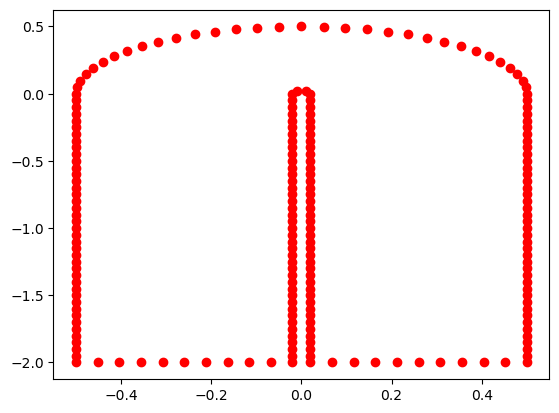

In [168]:
coordenadas = nodes[:, boundary_nodes]

plt.plot(coordenadas[0, :], coordenadas[1, :], 'ro')

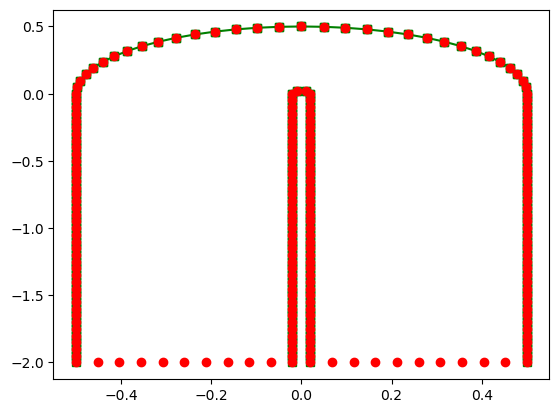

In [169]:
facets_e_list = []
for i, e in enumerate(boundary_facets):
    facets_e = facets[:, e]
    facets_e_list.append(facets_e)
    nodosx    = nodes[0, facets_e]
    nodosy    = nodes[1, facets_e]

    # plt.plot(nodosx, nodosy, 's-', color = 'b')

for i, e in enumerate(pared):
    facets_e = facets[:, e]
    nodosx    = nodes[0, facets_e]
    nodosy    = nodes[1, facets_e]

    plt.plot(nodosx, nodosy, 's-', color = 'g')

plt.plot(coordenadas[0, :], coordenadas[1, :], 'ro')

In [170]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(malla, element['u'], intorder=4),
    'p': Basis(malla, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

In [210]:
@LinearForm
def mean_vec(q, w):
    return q

m    = asm(mean_vec, basis_p)    # shape: (Np,)
Mcol = m.reshape((-1, 1))     # (Np,1)
Mrow = m.reshape((1,  -1))    # (1,Np)

In [ ]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)
nu = 0.035
# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   
M =  asm(mass_matrix, basis_u)   


# Construcción del ssitema
K = bmat([[nu*A,    B.T, None],
          [B,    None, Mcol],
          [None, Mrow, np.array([1])]], format='csr') 

zeros = sp.csr_matrix((basis_p.N, basis_p.N))  
L = bmat([[M,   None, None],
          [None, zeros, Mcol*0],
          [None, Mrow*0, None]], format='csr')


In [239]:
D_all = np.unique(np.concatenate([
    basis_u.get_dofs(pared).all(),
    # Nu + np.array([0])
]) )

In [240]:
A_sys, xI, I   = condense(K, D=D_all)
M_sys, xIM, IM = condense(L, D=D_all)

In [241]:
vals, vecs = eigs(A_sys, k=10, M=M_sys, sigma=0.0, which='LM', OPpart='r')

In [254]:
# Filtrar valores propios reales (parte imaginaria exactamente cero)
mask_real = np.isclose(vals.imag, 0)
vals = vals[mask_real].real
vecs = vecs[:, mask_real].real

# Ordenar autovalores
idx = np.argsort(vals)
eigenvalues = vals[idx]
eigenvectors = vecs[:, idx]

# Insertar la solución reducida en el vector global (con ceros en frontera)
u_sol = np.zeros(K.shape[0])

sol_idx = 0
u_sol[I] = eigenvectors[:, sol_idx]  # Primer modo

# Separar componentes de velocidad y presión
u_velocity = u_sol[:Nu]
p_pressure = u_sol[Nu:]
# graficar_stokes(u_velocity, p_pressure, mesh, basis_p, basis_u)

In [255]:
eigenvalues

array([1.57024698, 1.69972055, 5.07823332, 5.0782996 , 5.40605374,
       5.47721179, 5.69268722, 5.71370207, 5.71907687, 5.78166827])

In [256]:
# plt.quiver(x_edges[:, 0], x_edges[:, 1], eigfunc_x[m.verts.shape[0]:,idx_eig], eigfunc_y[m.verts.shape[0]:,idx_eig])


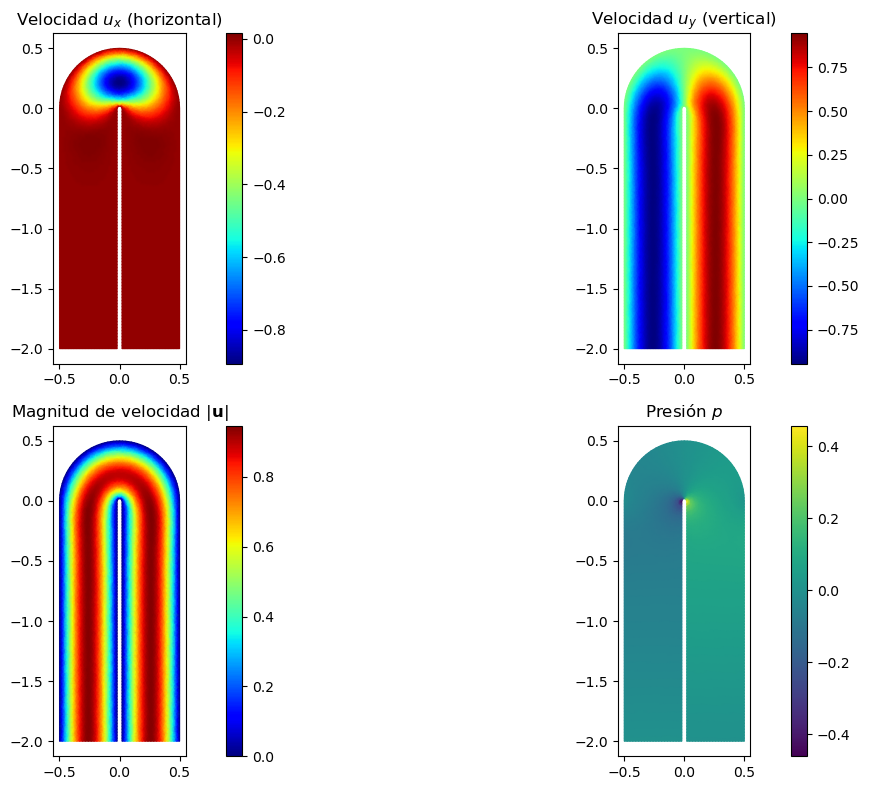

In [257]:
graficar_stokes(u_velocity, p_pressure, malla, basis_p, basis_u)

In [189]:
eigenvalues

array([ 44.83431413, 145.09237427, 145.09427385, 154.37359288,
       155.62781337, 162.63536401, 163.24597753, 163.37471339,
       165.10525997, 167.17516301])

In [202]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True, colormap='viridis', cmap='viridis')
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()
